# MNIST数据集使用LeNet进行图像分类
本示例教程演示如何在MNIST数据集上用LeNet进行图像分类。
手写数字的MNIST数据集，包含60,000个用于训练的示例和10,000个用于测试的示例。这些数字已经过尺寸标准化并位于图像中心，图像是固定大小(28x28像素)，其值为0到1。该数据集的官方地址为：http://yann.lecun.com/exdb/mnist/

# 环境
本教程基于paddle-develop编写，如果您的环境不是本版本，请先安装paddle-develop版本。

In [35]:
import paddle
print(paddle.__version__)
paddle.disable_static()

0.0.0


# 加载数据集
我们使用飞桨自带的paddle.dataset完成mnist数据集的加载。

In [36]:
print('download training data and load training data')
train_dataset = paddle.vision.datasets.MNIST(mode='train')
test_dataset = paddle.vision.datasets.MNIST(mode='test')
print('load finished')

download training data and load training data
load finished


取训练集中的一条数据看一下。

train_data0 label is: [5]


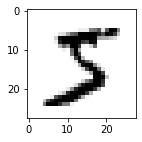

In [37]:
import numpy as np
import matplotlib.pyplot as plt
train_data0, train_label_0 = train_dataset[0][0],train_dataset[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
print('train_data0 label is: ' + str(train_label_0))

# 2.组网
用paddle.nn下的API，如`Conv2d`、`Pool2D`、`Linead`完成LeNet的构建。

In [38]:
import paddle
import paddle.nn.functional as F
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2d(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=16*5*5, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = paddle.reshape(x, shape=[-1, 16*5*5])
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x)
        return x

# 3.训练方式一
组网后，开始对模型进行训练，先构建`train_loader`，加载训练数据，然后定义`train`函数，设置好损失函数后，按batch加载数据，完成模型的训练。

In [39]:
import paddle
train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载训练集 batch_size 设为 64
def train(model):
    model.train()
    epochs = 2
    optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    # 用Adam作为优化函数
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            loss = paddle.nn.functional.cross_entropy(predicts, y_data)
            # 计算损失
            acc = paddle.metric.accuracy(predicts, y_data, k=2)
            avg_loss = paddle.mean(loss)
            avg_acc = paddle.mean(acc)
            avg_loss.backward()
            if batch_id % 100 == 0:
                print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, avg_loss.numpy(), avg_acc.numpy()))
            optim.minimize(avg_loss)
            model.clear_gradients()
model = LeNet()
train(model)

epoch: 0, batch_id: 0, loss is: [2.3064885], acc is: [0.109375]
epoch: 0, batch_id: 100, loss is: [1.5477252], acc is: [1.]
epoch: 0, batch_id: 200, loss is: [1.5201148], acc is: [1.]
epoch: 0, batch_id: 300, loss is: [1.525354], acc is: [0.953125]
epoch: 0, batch_id: 400, loss is: [1.5201038], acc is: [1.]
epoch: 0, batch_id: 500, loss is: [1.4901408], acc is: [1.]
epoch: 0, batch_id: 600, loss is: [1.4925538], acc is: [0.984375]
epoch: 0, batch_id: 700, loss is: [1.5247533], acc is: [0.96875]
epoch: 0, batch_id: 800, loss is: [1.5365943], acc is: [1.]
epoch: 0, batch_id: 900, loss is: [1.5154861], acc is: [0.984375]
epoch: 1, batch_id: 0, loss is: [1.4988302], acc is: [0.984375]
epoch: 1, batch_id: 100, loss is: [1.493154], acc is: [0.984375]
epoch: 1, batch_id: 200, loss is: [1.4974915], acc is: [1.]
epoch: 1, batch_id: 300, loss is: [1.5089471], acc is: [0.984375]
epoch: 1, batch_id: 400, loss is: [1.5041347], acc is: [1.]
epoch: 1, batch_id: 500, loss is: [1.5145375], acc is: [1.]

### 对模型进行验证
训练完成后，需要验证模型的效果，此时，加载测试数据集，然后用训练好的模对测试集进行预测，计算损失与精度。

In [40]:
import paddle
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=64)
# 加载测试数据集
def test(model):
    model.eval()
    batch_size = 64
    for batch_id, data in enumerate(train_loader()):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        # 获取预测结果
        loss = paddle.nn.functional.cross_entropy(predicts, y_data)
        acc = paddle.metric.accuracy(predicts, y_data, k=2)
        avg_loss = paddle.mean(loss)
        avg_acc = paddle.mean(acc)
        avg_loss.backward()
        if batch_id % 100 == 0:
            print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id, avg_loss.numpy(), avg_acc.numpy()))
test(model)

batch_id: 0, loss is: [1.4659549], acc is: [1.]
batch_id: 100, loss is: [1.4933192], acc is: [0.984375]
batch_id: 200, loss is: [1.4779761], acc is: [1.]
batch_id: 300, loss is: [1.4919193], acc is: [0.984375]
batch_id: 400, loss is: [1.5036212], acc is: [1.]
batch_id: 500, loss is: [1.4922347], acc is: [0.984375]
batch_id: 600, loss is: [1.4765416], acc is: [0.984375]
batch_id: 700, loss is: [1.4997746], acc is: [0.984375]
batch_id: 800, loss is: [1.4831288], acc is: [1.]
batch_id: 900, loss is: [1.498342], acc is: [0.984375]


### 训练方式一结束
以上就是训练方式一，通过这种方式，可以清楚的看到训练和测试中的每一步过程。但是，这种方式句法比较复杂。因此，我们提供了训练方式二，能够更加快速、高效的完成模型的训练与测试。

## 3.训练方式二
通过paddle提供的`Model` 构建实例，使用封装好的训练与测试接口，快速完成模型训练与测试。

In [41]:
import paddle
from paddle.static import InputSpec
from paddle.metric import Accuracy
inputs = InputSpec([None, 784], 'float32', 'x')
labels = InputSpec([None, 10], 'float32', 'x')
model = paddle.Model(LeNet(), inputs, labels)
optim = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())

model.prepare(
    optim,
    paddle.nn.loss.CrossEntropyLoss(),
    Accuracy(topk=(1, 2))
    )

### 使用model.fit来训练模型

In [42]:
model.fit(train_dataset,
        epochs=2,
        batch_size=64,
        save_dir='mnist_checkpoint')

Epoch 1/2
step  10/938 - loss: 2.2434 - acc_top1: 0.1344 - acc_top2: 0.3719 - 14ms/step
step  20/938 - loss: 2.0292 - acc_top1: 0.2836 - acc_top2: 0.4633 - 14ms/step
step  30/938 - loss: 1.9341 - acc_top1: 0.3755 - acc_top2: 0.5214 - 14ms/step
step  40/938 - loss: 1.8009 - acc_top1: 0.4469 - acc_top2: 0.5727 - 14ms/step
step  50/938 - loss: 1.8000 - acc_top1: 0.4975 - acc_top2: 0.6125 - 13ms/step
step  60/938 - loss: 1.6335 - acc_top1: 0.5417 - acc_top2: 0.6438 - 14ms/step
step  70/938 - loss: 1.7931 - acc_top1: 0.5708 - acc_top2: 0.6643 - 13ms/step
step  80/938 - loss: 1.6699 - acc_top1: 0.5961 - acc_top2: 0.6846 - 13ms/step
step  90/938 - loss: 1.6832 - acc_top1: 0.6189 - acc_top2: 0.7069 - 13ms/step
step 100/938 - loss: 1.6336 - acc_top1: 0.6409 - acc_top2: 0.7245 - 14ms/step
step 110/938 - loss: 1.6598 - acc_top1: 0.6557 - acc_top2: 0.7376 - 13ms/step
step 120/938 - loss: 1.6348 - acc_top1: 0.6708 - acc_top2: 0.7488 - 13ms/step
step 130/938 - loss: 1.6223 - acc_top1: 0.6851 - acc_t

step 110/938 - loss: 1.5484 - acc_top1: 0.8848 - acc_top2: 0.9017 - 14ms/step
step 120/938 - loss: 1.5904 - acc_top1: 0.8840 - acc_top2: 0.9020 - 14ms/step
step 130/938 - loss: 1.5108 - acc_top1: 0.8852 - acc_top2: 0.9025 - 14ms/step
step 140/938 - loss: 1.6199 - acc_top1: 0.8840 - acc_top2: 0.9016 - 14ms/step
step 150/938 - loss: 1.5337 - acc_top1: 0.8842 - acc_top2: 0.9019 - 13ms/step
step 160/938 - loss: 1.6094 - acc_top1: 0.8846 - acc_top2: 0.9023 - 13ms/step
step 170/938 - loss: 1.5653 - acc_top1: 0.8843 - acc_top2: 0.9019 - 13ms/step
step 180/938 - loss: 1.5978 - acc_top1: 0.8835 - acc_top2: 0.9011 - 13ms/step
step 190/938 - loss: 1.5950 - acc_top1: 0.8833 - acc_top2: 0.9012 - 13ms/step
step 200/938 - loss: 1.6422 - acc_top1: 0.8828 - acc_top2: 0.9002 - 13ms/step
step 210/938 - loss: 1.5752 - acc_top1: 0.8831 - acc_top2: 0.9004 - 13ms/step
step 220/938 - loss: 1.6635 - acc_top1: 0.8832 - acc_top2: 0.9001 - 13ms/step
step 230/938 - loss: 1.5726 - acc_top1: 0.8823 - acc_top2: 0.899

### 使用model.evaluate来预测模型

In [43]:
model.evaluate(test_dataset, batch_size=64)

Eval begin...
step  10/157 - loss: 1.5447 - acc_top1: 0.8953 - acc_top2: 0.9078 - 5ms/step
step  20/157 - loss: 1.6185 - acc_top1: 0.8930 - acc_top2: 0.9078 - 5ms/step
step  30/157 - loss: 1.6497 - acc_top1: 0.8917 - acc_top2: 0.9057 - 5ms/step
step  40/157 - loss: 1.6318 - acc_top1: 0.8902 - acc_top2: 0.9055 - 5ms/step
step  50/157 - loss: 1.5533 - acc_top1: 0.8856 - acc_top2: 0.9012 - 5ms/step
step  60/157 - loss: 1.6212 - acc_top1: 0.8878 - acc_top2: 0.9036 - 5ms/step
step  70/157 - loss: 1.5674 - acc_top1: 0.8839 - acc_top2: 0.9002 - 5ms/step
step  80/157 - loss: 1.5409 - acc_top1: 0.8891 - acc_top2: 0.9043 - 5ms/step
step  90/157 - loss: 1.6133 - acc_top1: 0.8903 - acc_top2: 0.9045 - 5ms/step
step 100/157 - loss: 1.5535 - acc_top1: 0.8909 - acc_top2: 0.9044 - 5ms/step
step 110/157 - loss: 1.5690 - acc_top1: 0.8916 - acc_top2: 0.9054 - 5ms/step
step 120/157 - loss: 1.6147 - acc_top1: 0.8926 - acc_top2: 0.9055 - 5ms/step
step 130/157 - loss: 1.5203 - acc_top1: 0.8944 - acc_top2: 0.9

{'loss': [1.585474], 'acc_top1': 0.8956, 'acc_top2': 0.9076}

### 训练方式二结束
以上就是训练方式二，可以快速、高效的完成网络模型训练与预测。

## 总结


以上就是用LeNet对手写数字数据及MNIST进行分类。本示例提供了两种训练模型的方式，一种可以快速完成模型的组建与预测，非常适合新手用户上手。另一种则需要多个步骤来完成模型的训练，适合进阶用户使用。